In [1]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
!pip install neattext
import neattext.functions as nfx
import matplotlib.pyplot as plt
import plotly.express as plx
from sklearn.metrics import classification_report
import keras
from keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 884.8 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

data=pd.read_csv("/content/drive/My Drive/Suicide_Detection.csv")
data.head()

from google.colab import drive
drive.mount('/content/drive')

data['class'].value_counts()

data['class'].value_counts().index.values

train_data,test_data=train_test_split(data,test_size=0.2,random_state=10)

train_data['class'].value_counts().index.values

plx.bar(train_data,x=train_data['class'].value_counts().index.values,
        y=train_data['class'].value_counts(),color=['Suicide','Not Suicide'])


Mounted at /content/drive
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


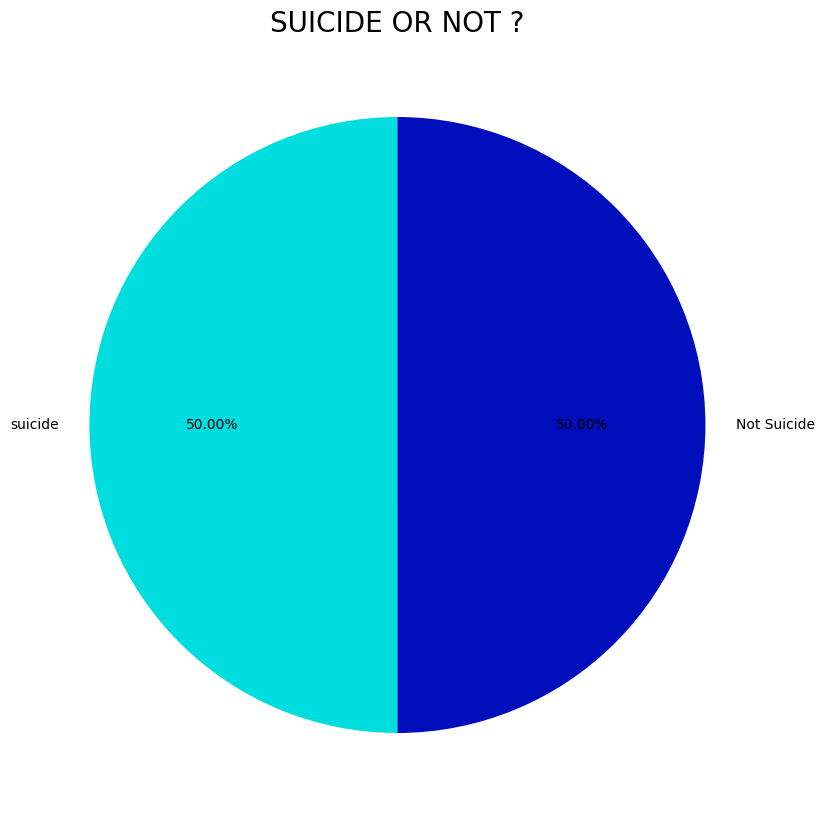

In [3]:
plt.figure(figsize=(12,10))
plt.pie(train_data['class'].value_counts(),startangle=90,colors=['#00dddf','#000fbb'],
        autopct='%0.2f%%',labels=['suicide','Not Suicide'])
plt.title('SUICIDE OR NOT ?',fontdict={'size':20})
plt.show()

In [4]:
def clean_text(text):
    text_length=[]
    cleaned_text=[]
    for sent in tqdm(text):
        sent=sent.lower()
        sent=nfx.remove_special_characters(sent)
        sent=nfx.remove_stopwords(sent)
#         sent=nfx.remove_shortwords(sent)
        text_length.append(len(sent.split()))
        cleaned_text.append(sent)
    return cleaned_text,text_length

100%|██████████| 46415/46415 [00:05<00:00, 9154.09it/s]


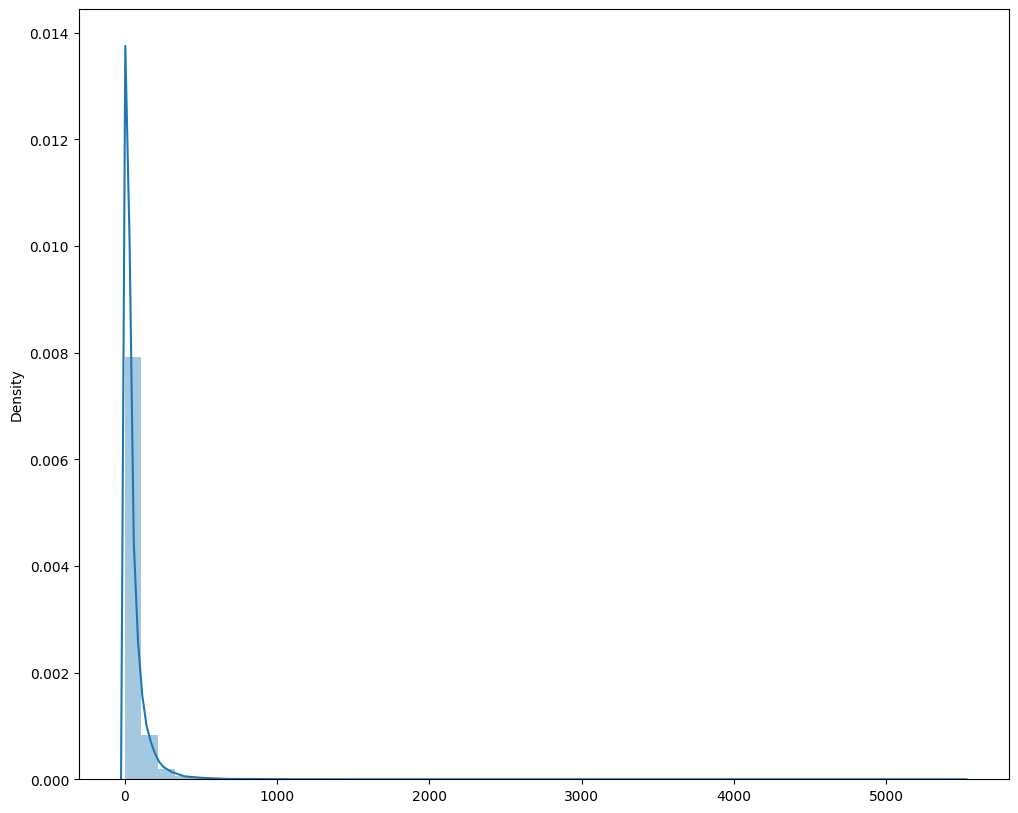

In [5]:
cleaned_train_text,train_text_length=clean_text(train_data.text)
cleaned_test_text,test_text_length=clean_text(test_data.text)

plt.figure(figsize=(12,10))
sns.distplot(train_text_length)
# plt.axis([-10,100,0,0.03])
plt.show()

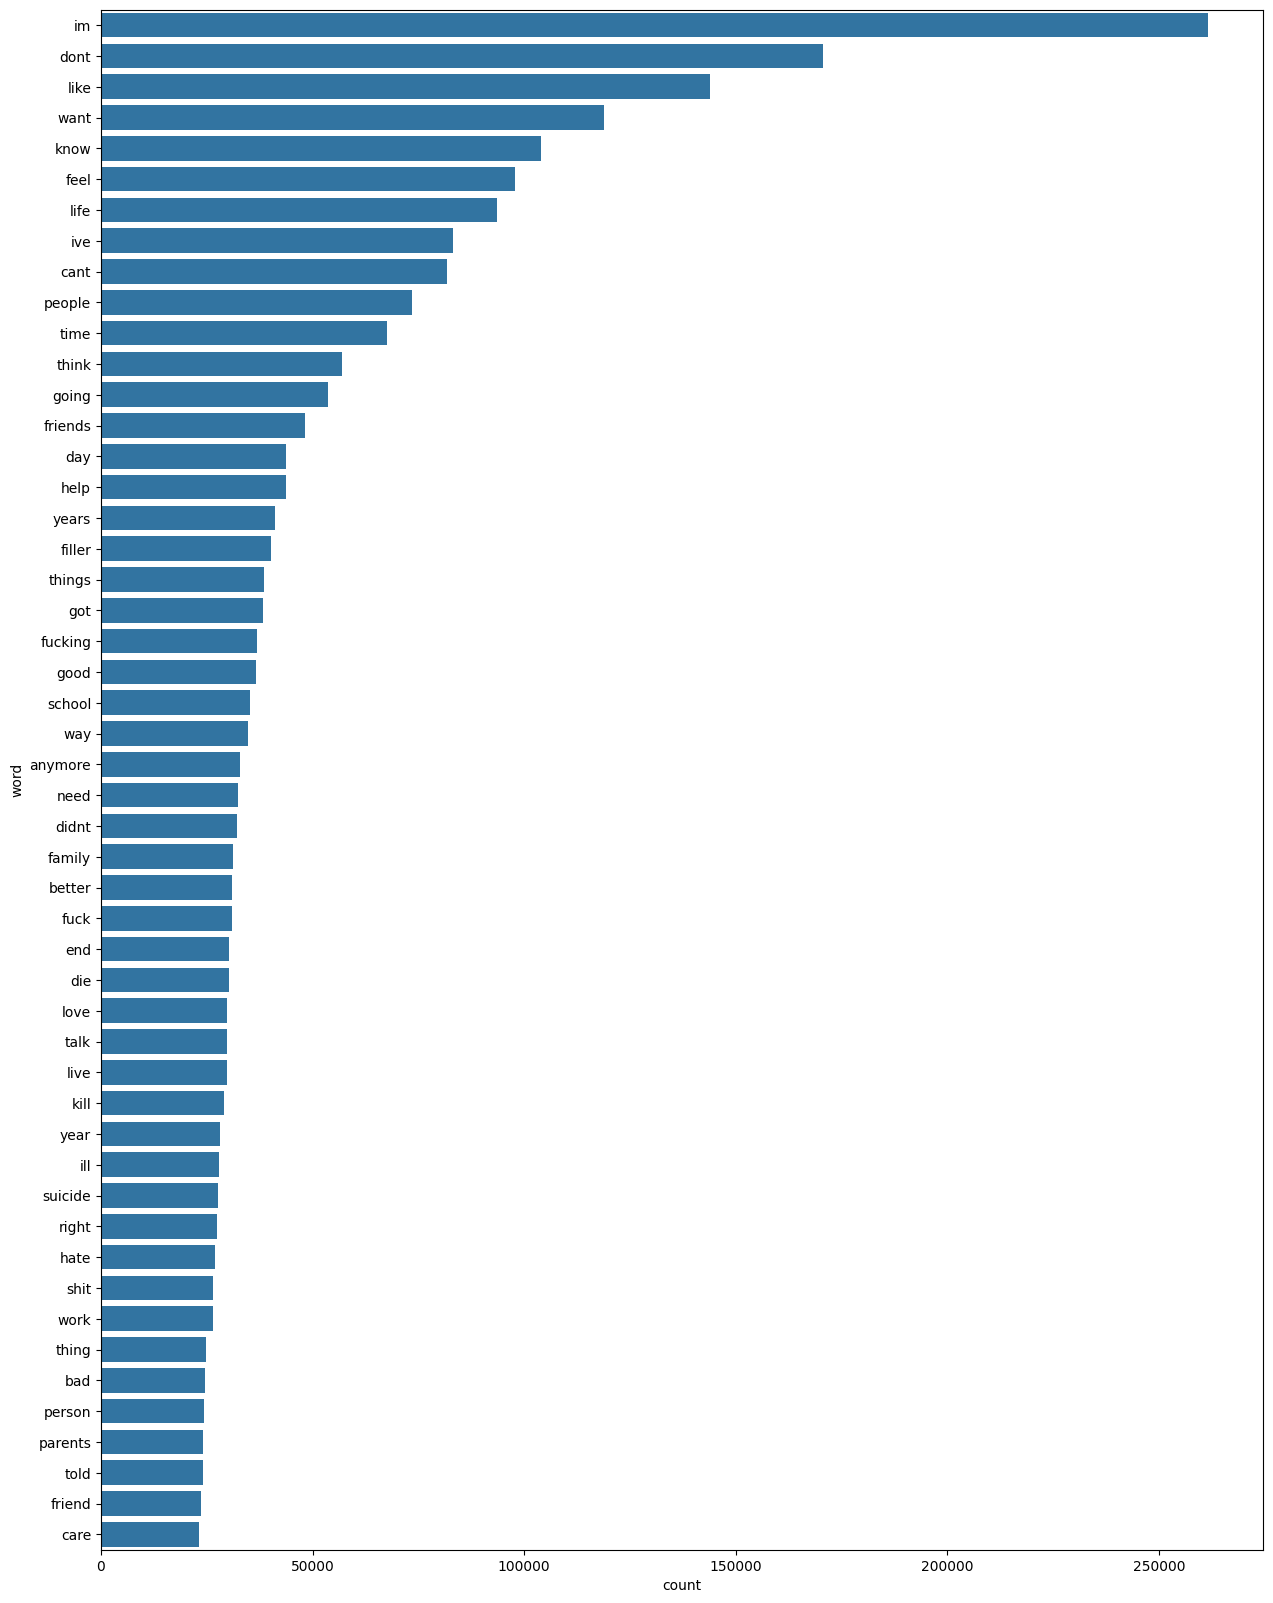

In [6]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(cleaned_train_text)

word_freq=pd.DataFrame(tokenizer.word_counts.items(),columns=['word','count']).sort_values(by='count',ascending=False)

plt.figure(figsize=(15,20))
sns.barplot(x='count',y='word',data=word_freq.iloc[:50])
plt.show()

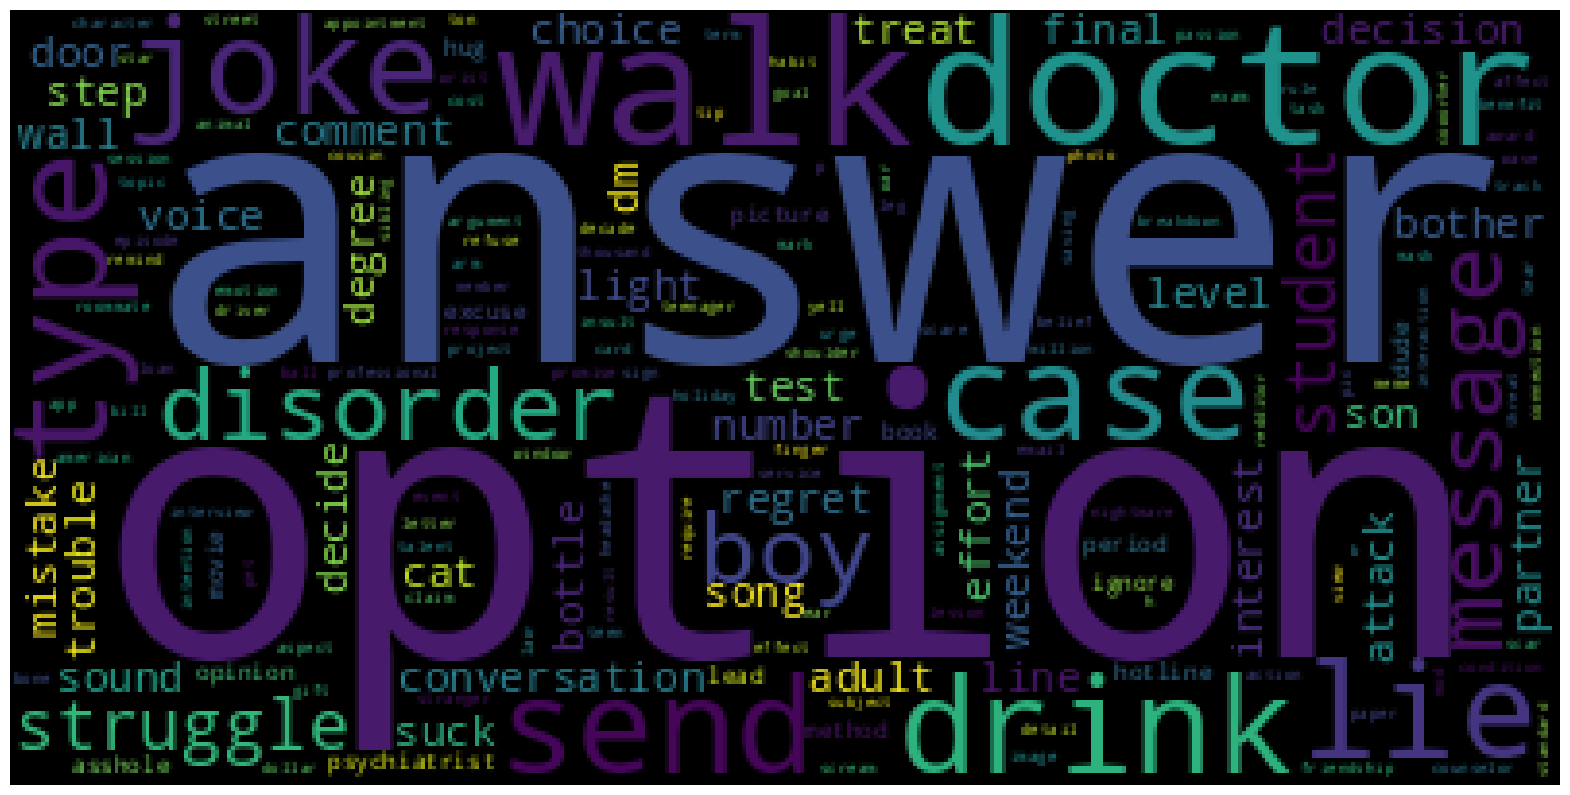

In [7]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

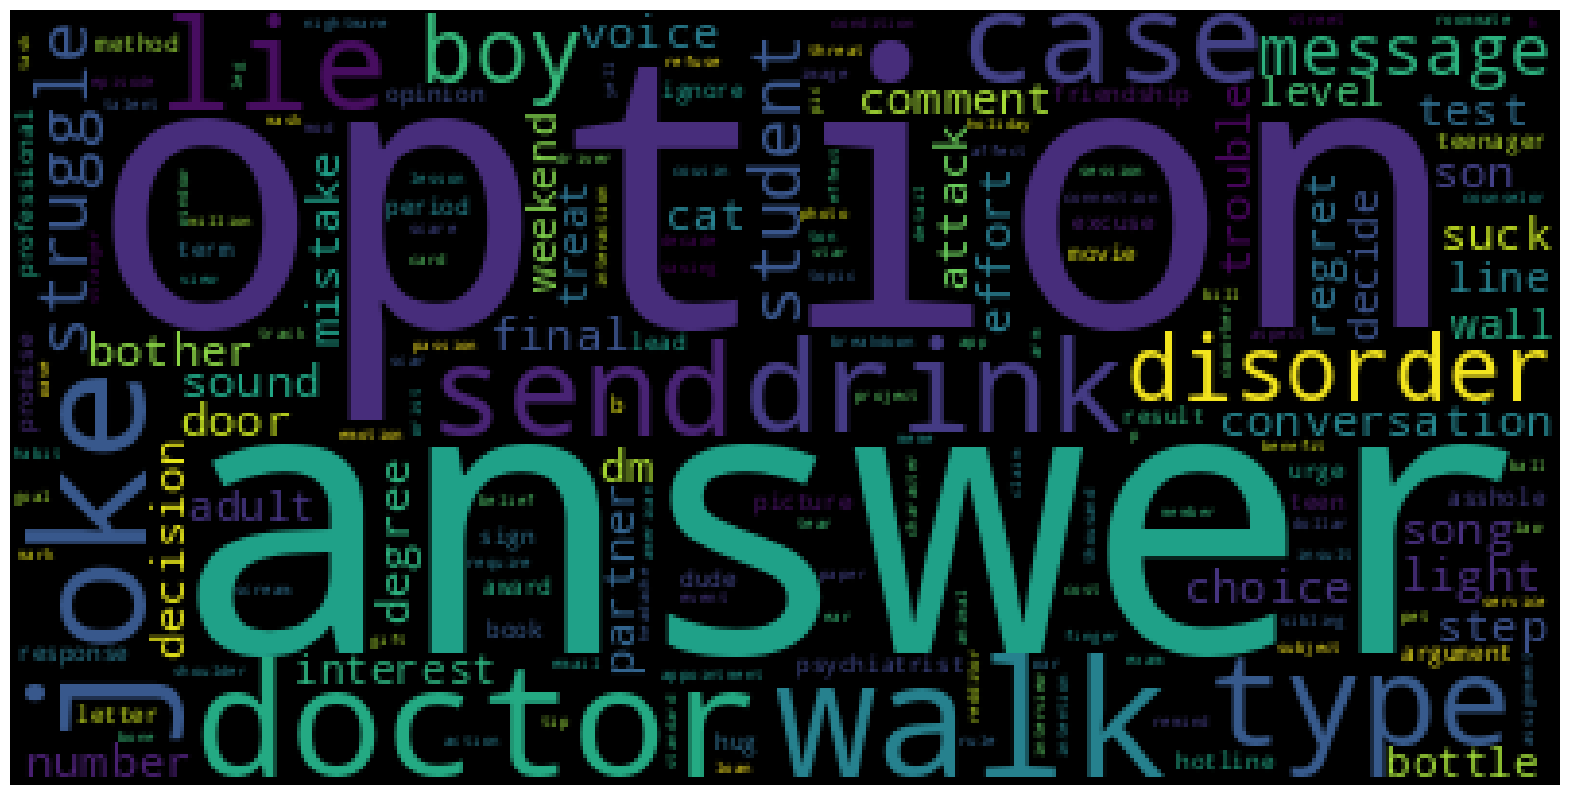

In [8]:
feature_names=word_freq['word'].values
wc=WordCloud(max_words=400)
wc.generate(' '.join(word for word in feature_names[500:3500] ))
plt.figure(figsize=(20,15))
plt.axis('off')
plt.imshow(wc)

In [9]:
test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [10]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [11]:
lbl_target=LabelEncoder()
train_output=lbl_target.fit_transform(train_data['class'])
test_output=lbl_target.transform(test_data['class'])

In [13]:
# glove_embedding={}
with open('/content/drive/My Drive/glove.840B.300d.pkl', 'rb') as glEmb:
    glove_embedding = pickle.load(glEmb)

In [14]:
v=len(tokenizer.word_index)


In [15]:
embedding_matrix=np.zeros((v+1,300), dtype=float)
for word,idx in tokenizer.word_index.items():
    embedding_vector=glove_embedding.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx]=embedding_vector

In [16]:
early_stop=EarlyStopping(patience=5)
reducelr=ReduceLROnPlateau(patience=3)

In [17]:
model=Sequential()
model.add(Input(shape=(50,)))
model.add(Embedding(v+1,300,weights=[embedding_matrix],trainable=False))
model.add(LSTM(20,return_sequences=True))
model.add(GlobalMaxPooling1D())
#     model.add(Dropout(0.3))
model.add(Dense(256,activation='relu'))
#     model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.SGD(0.1,momentum=0.09),loss='binary_crossentropy',metrics=['accuracy'])
#model.compile(
 #    optimizer = tf.keras.optimizers.SGD(0.1,momentum=0.09),
  #   loss = 'binary_crossentropy',
   #  metrics = ["accuracy"]
    #)

In [19]:
train_text_seq=tokenizer.texts_to_sequences(cleaned_train_text)
train_text_pad=pad_sequences(train_text_seq,maxlen=50)


test_text_seq=tokenizer.texts_to_sequences(cleaned_test_text)
test_text_pad=pad_sequences(test_text_seq,maxlen=50)

In [20]:
r=model.fit(train_text_pad,train_output,validation_data=(test_text_pad,test_output),
            epochs=20,batch_size=256,callbacks=[early_stop,reducelr])

Epoch 1/20
726/726 [==============================] - 78s 102ms/step - loss: 0.3456 - accuracy: 0.8509 - val_loss: 0.2479 - val_accuracy: 0.9012 - lr: 0.1000
Epoch 2/20
726/726 [==============================] - 78s 107ms/step - loss: 0.2459 - accuracy: 0.9021 - val_loss: 0.2381 - val_accuracy: 0.9046 - lr: 0.1000
Epoch 3/20
726/726 [==============================] - 75s 103ms/step - loss: 0.2210 - accuracy: 0.9128 - val_loss: 0.2136 - val_accuracy: 0.9164 - lr: 0.1000
Epoch 4/20
726/726 [==============================] - 74s 102ms/step - loss: 0.1990 - accuracy: 0.9221 - val_loss: 0.3287 - val_accuracy: 0.8685 - lr: 0.1000
Epoch 5/20
726/726 [==============================] - 77s 106ms/step - loss: 0.1840 - accuracy: 0.9280 - val_loss: 0.2221 - val_accuracy: 0.9144 - lr: 0.1000
Epoch 6/20
726/726 [==============================] - 75s 103ms/step - loss: 0.1750 - accuracy: 0.9320 - val_loss: 0.1888 - val_accuracy: 0.9269 - lr: 0.1000
Epoch 7/20
726/726 [==============================] 

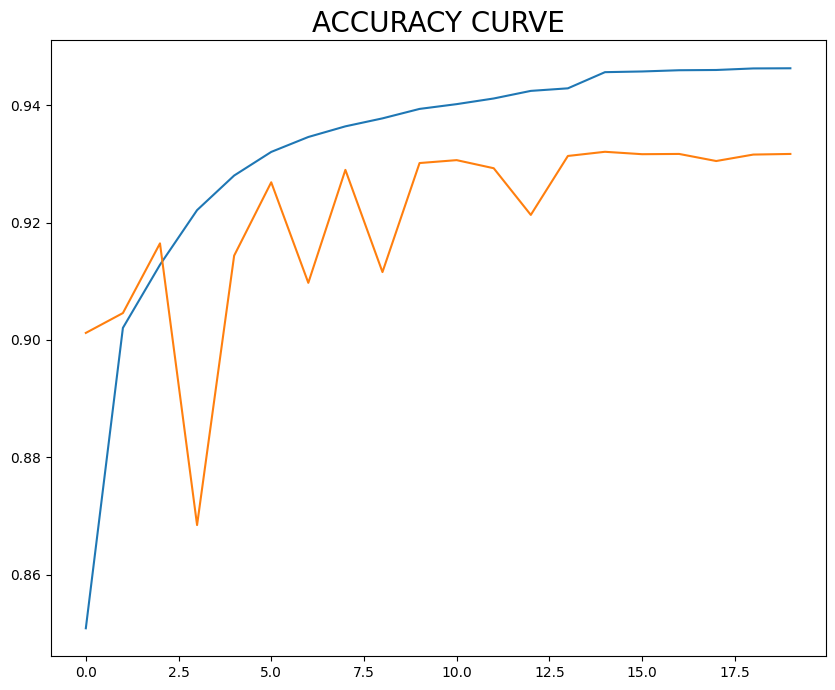

In [21]:
plt.figure(figsize=(10,8))
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])
plt.title('ACCURACY CURVE',fontdict={'size':20})
plt.show()

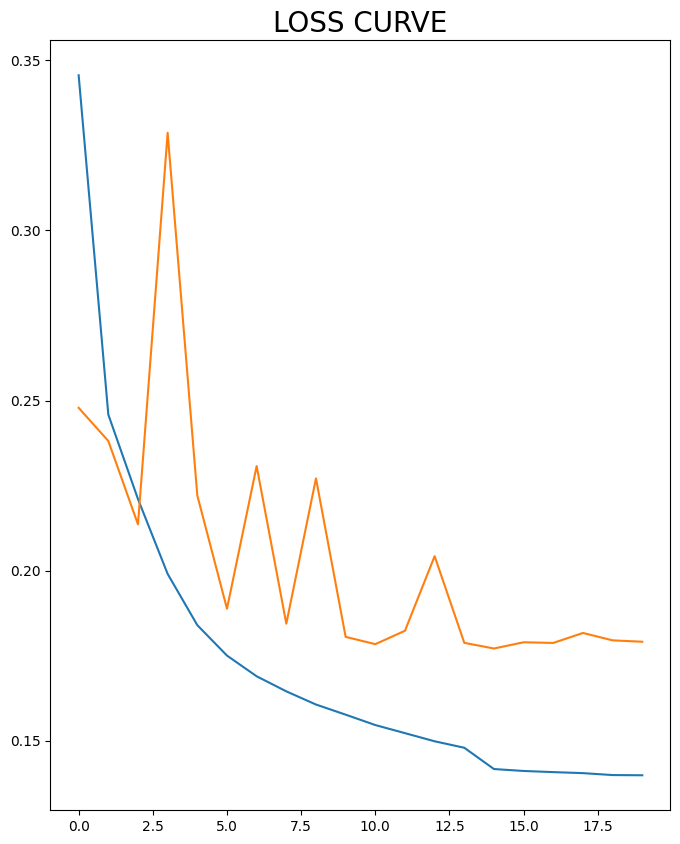

In [22]:
plt.figure(figsize=(8,10))
plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('LOSS CURVE',fontdict={'size':20})
plt.show()

In [23]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')

TESTING DATA CLASSIFICATION REPORT 
 



In [24]:
score, acc = model.evaluate(test_text_pad,test_output,verbose=2, batch_size= 256)
print('TRAINING DATA CLASSIFICATION REPORT \n \n',score,acc)

182/182 - 10s - loss: 0.1791 - accuracy: 0.9317 - 10s/epoch - 55ms/step
TRAINING DATA CLASSIFICATION REPORT 
 
 0.1791093498468399 0.9316815733909607


In [25]:
print('TESTING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(test_output,model.predict(test_text_pad)==1,
                            target_names=lbl_target.inverse_transform([0,1])))
print('\n n')
print('TRAINING DATA CLASSIFICATION REPORT \n \n')
print(classification_report(train_output,model.predict(train_text_pad)==1,
                           target_names=lbl_target.inverse_transform([0,1])))

TESTING DATA CLASSIFICATION REPORT 
 

1451/1451 [==============================] - 19s 12ms/step
              precision    recall  f1-score   support

 non-suicide       0.50      1.00      0.67     23209
     suicide       0.00      0.00      0.00     23206

    accuracy                           0.50     46415
   macro avg       0.25      0.50      0.33     46415
weighted avg       0.25      0.50      0.33     46415


 n
TRAINING DATA CLASSIFICATION REPORT 
 

5802/5802 [==============================] - 66s 11ms/step
              precision    recall  f1-score   support

 non-suicide       0.50      1.00      0.67     92828
     suicide       0.00      0.00      0.00     92831

    accuracy                           0.50    185659
   macro avg       0.25      0.50      0.33    185659
weighted avg       0.25      0.50      0.33    185659



In [28]:
a=['I am feeling  depressed and im going to suicide']
def pre(a:str):
  a_clean,a_length = clean_text(a)
  a_clean_seq=tokenizer.texts_to_sequences(a_clean)
  a_clean_pad=pad_sequences(a_clean_seq,maxlen=50)
  print('\n')
  print(model.predict(a_clean_pad))
pre(a)

100%|██████████| 1/1 [00:00<00:00, 5622.39it/s]



1/1 [==============================] - 0s 43ms/step
[[0.9533167]]


In [29]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [31]:
! pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [39]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [40]:
model.save("model.h5")

In [50]:
a=['']
def pre(a:str):
  a_clean,a_length = clean_text(a)
  a_clean_seq=tokenizer.texts_to_sequences(a_clean)
  a_clean_pad=pad_sequences(a_clean_seq,maxlen=50)
  print('\n')
  print(model.predict(a_clean_pad))
pre(a)

100%|██████████| 1/1 [00:00<00:00, 4438.42it/s]



1/1 [==============================] - 0s 51ms/step
[[0.8215423]]
